In [7]:
using POMDPs
using QuickPOMDPs
using Distributions
using Distributions: DiscreteUniform, pdf
using POMDPTools: Deterministic
using POMDPTools
using Statistics
using POMDPs: states, actions, transition, reward
using TabularTDLearning
using Random
using StatsBase: Weights
using Plots
using DataFrames

In [ ]:
const MAX_INVENTORY = 20
const MAX_STORE = 10
const ORDER_SIZE = 5

const holding_cost_store = 2
const holding_cost_parking = 4
const order_cost = 20
const stockout_penalty = 50

const demand_dist = DiscreteUniform(0, 10)

mdp = QuickMDP(
    states = 0:MAX_INVENTORY,
    actions = [0, 1],
    discount = 0.99,
    transition = function (s, a)
        outcomes = []
        order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
        new_stock = s + order_qty
        for d in support(demand_dist)
            sold = min(d, new_stock)
            next_state = new_stock - sold
            prob = pdf(demand_dist, d)
            push!(outcomes, (next_state, prob))
        end
        return outcomes
    end,
    reward = function (s, a, sp)
        order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
        new_stock = s + order_qty
        demand = new_stock - sp

        in_store = min(sp, MAX_STORE)
        in_parking = max(sp - MAX_STORE, 0)

        cost = 0
        cost += a == 1 ? order_cost : 0
        cost += in_store * holding_cost_store + in_parking * holding_cost_parking
        cost += max(demand - new_stock, 0) * stockout_penalty

        return -cost
    end,
    initialstate = Deterministic(10)
)

QuickMDP{Base.UUID("a118d4bb-7aa3-4442-ab58-0e93e68551c6"), Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, actionindex::Dict{Int64, Int64}, transition::var"#15#17", reward::var"#16#18", states::UnitRange{Int64}, actions::Vector{Int64}, discount::Float64, initialstate::Deterministic{Int64}}}((stateindex = Dict(5 => 6, 16 => 17, 7 => 8, 20 => 21, 12 => 13, 8 => 9, 17 => 18, 1 => 2, 19 => 20, 0 => 1…), isterminal = false, actionindex = Dict(0 => 1, 1 => 2), transition = var"#15#17"(), reward = var"#16#18"(), states = 0:20, actions = [0, 1], discount = 0.99, initialstate = Deterministic{Int64}(10)))

In [9]:
s = 5  # Start state
a = 0   # Action: order

for (sp, p) in transition(mdp, s, a)
    r = reward(mdp, s, a, sp)
    println("From $s --(a=$a)--> $sp  | P=$p, Reward=$r")
end

From 5 --(a=0)--> 5  | P=0.09090909090909091, Reward=-10
From 5 --(a=0)--> 4  | P=0.09090909090909091, Reward=-8
From 5 --(a=0)--> 3  | P=0.09090909090909091, Reward=-6
From 5 --(a=0)--> 2  | P=0.09090909090909091, Reward=-4
From 5 --(a=0)--> 1  | P=0.09090909090909091, Reward=-2
From 5 --(a=0)--> 0  | P=0.09090909090909091, Reward=0
From 5 --(a=0)--> 0  | P=0.09090909090909091, Reward=0
From 5 --(a=0)--> 0  | P=0.09090909090909091, Reward=0
From 5 --(a=0)--> 0  | P=0.09090909090909091, Reward=0
From 5 --(a=0)--> 0  | P=0.09090909090909091, Reward=0
From 5 --(a=0)--> 0  | P=0.09090909090909091, Reward=0


In [ ]:
function q_learning(mdp, alpha = 0.2, eps = 0.2, episodes = 100, max_steps = 100)
    st = collect(states(mdp))
    ac = collect(actions(mdp))
    Q = Dict((s, a) => 0.0 for s in st, a in ac)
    s = initialstate 

In [11]:
function ε_greedy_action(Q, s, actions, ε)
    if rand() < ε
        return rand(actions)
    else
        return argmax(a -> Q[s][a], actions)
    end
end

ε_greedy_action (generic function with 1 method)

In [12]:
function sarsa_learn(mdp, α, ε, γ=0.99; episodes=10_000, max_steps=100)
    sta = collect(states(mdp))
    ac = collect(actions(mdp))

    Q = Dict(s => Dict(a => 0.0 for a in ac) for s in sta)
    rng = MersenneTwister(42)

    for ep in 1:episodes
        s = rand(rng, sta)
        a = ε_greedy_action(Q, s, ac, ε)

        for step in 1:max_steps
            transitions = transition(mdp, s, a)
            probs = [p for (_, p) in transitions]
            next_states = [sp for (sp, _) in transitions]
            s′ = sample(rng, next_states, Weights(probs))

            r = reward(mdp, s, a, s′)
            a′ = ε_greedy_action(Q, s′, ac, ε)

            Q[s][a] += α * (r + γ * Q[s′][a′] - Q[s][a])
            s, a = s′, a′
        end
    end

    policy = Dict(s => argmax(a -> Q[s][a], ac) for s in sta)
    return policy, Q
end


sarsa_learn (generic function with 2 methods)

In [13]:
# function train_sarsa_agent(mdp, alpha, epsilon; iterations=10_000)
#     sarsa = SARSASolver(
#         max_iterations=iterations,
#         alpha=alpha,
#         epsilon=epsilon,
#         gamma=mdp.discount
#     )
#     policy = solve(sarsa, mdp)
#     return policy
# end

In [14]:
policy, Q = sarsa_learn(mdp, 0.9, 0.9)

println("SARSA Policy:")
for st in sort(collect(keys(policy)))
    println("Inventory $st → Action: ", policy[st] == 1 ? "Order" : "Do Not Order")
end

SARSA Policy:
Inventory 0 → Action: Do Not Order
Inventory 1 → Action: Do Not Order
Inventory 2 → Action: Do Not Order
Inventory 3 → Action: Do Not Order
Inventory 4 → Action: Do Not Order
Inventory 5 → Action: Do Not Order
Inventory 6 → Action: Do Not Order
Inventory 7 → Action: Order
Inventory 8 → Action: Do Not Order
Inventory 9 → Action: Order
Inventory 10 → Action: Do Not Order
Inventory 11 → Action: Do Not Order
Inventory 12 → Action: Do Not Order
Inventory 13 → Action: Do Not Order
Inventory 14 → Action: Order
Inventory 15 → Action: Do Not Order
Inventory 16 → Action: Do Not Order
Inventory 17 → Action: Do Not Order
Inventory 18 → Action: Do Not Order
Inventory 19 → Action: Order
Inventory 20 → Action: Do Not Order


In [15]:
function evaluate_policy(mdp, policy; episodes=100, max_steps=100)
    total_reward = 0.0
    rng = MersenneTwister(123)

    for _ in 1:episodes
        s = 10  # initial inventory
        r_total = 0.0
        for _ in 1:max_steps
            a = policy[s]
            trans = transition(mdp, s, a)
            probs = [p for (_, p) in trans]
            next_states = [sp for (sp, _) in trans]
            s′ = sample(rng, next_states, Weights(probs))
            r = reward(mdp, s, a, s′)
            r_total += r
            s = s′
        end
        total_reward += r_total
    end

    return total_reward / episodes
end

evaluate_policy (generic function with 1 method)

In [16]:
alphas = [0.2, 0.1, 0.01, 1e-5]
epsilons = [0.2, 0.1, 0.01, 1e-5]

results = []

for α in alphas, ε in epsilons
    println("Training SARSA with α = $α, ε = $ε")
    policy, Q = sarsa_learn(mdp, α, ε)
    avg_reward = evaluate_policy(mdp, policy)
    push!(results, (α, ε, round(avg_reward, digits=2)))
end

println("\nPerformance Summary (Average Reward per Policy):")
println("α\tϵ\tAverage Reward")
for (α, ε, reward) in results
    println("$α\t$ε\t$reward")
end

Training SARSA with α = 0.2, ε = 0.2
Training SARSA with α = 0.2, ε = 0.1
Training SARSA with α = 0.2, ε = 0.01
Training SARSA with α = 0.2, ε = 1.0e-5
Training SARSA with α = 0.1, ε = 0.2
Training SARSA with α = 0.1, ε = 0.1
Training SARSA with α = 0.1, ε = 0.01
Training SARSA with α = 0.1, ε = 1.0e-5
Training SARSA with α = 0.01, ε = 0.2
Training SARSA with α = 0.01, ε = 0.1
Training SARSA with α = 0.01, ε = 0.01
Training SARSA with α = 0.01, ε = 1.0e-5
Training SARSA with α = 1.0e-5, ε = 0.2
Training SARSA with α = 1.0e-5, ε = 0.1
Training SARSA with α = 1.0e-5, ε = 0.01
Training SARSA with α = 1.0e-5, ε = 1.0e-5

Performance Summary (Average Reward per Policy):
α	ϵ	Average Reward
0.2	0.2	-15.72
0.2	0.1	-15.72
0.2	0.01	-15.72
0.2	1.0e-5	-15.72
0.1	0.2	-15.72
0.1	0.1	-15.72
0.1	0.01	-15.72
0.1	1.0e-5	-15.72
0.01	0.2	-15.72
0.01	0.1	-15.72
0.01	0.01	-15.72
0.01	1.0e-5	-15.72
1.0e-5	0.2	-21.4
1.0e-5	0.1	-103.44
1.0e-5	0.01	-21.62
1.0e-5	1.0e-5	-15.72


In [17]:
df = DataFrame(results, [:alpha, :epsilon, :avg_reward])
alphas = sort(unique(df.alpha))
epsilons = sort(unique(df.epsilon))

# Build Z matrix safely
Z = fill(NaN, length(alphas), length(epsilons))
for (i, α) in enumerate(alphas)
    for (j, ϵ) in enumerate(epsilons)
        row = filter(r -> r.alpha == α && r.epsilon == ϵ, eachrow(df))
        if !isempty(row)
            Z[i, j] = row[1][:avg_reward]
        end
    end
end


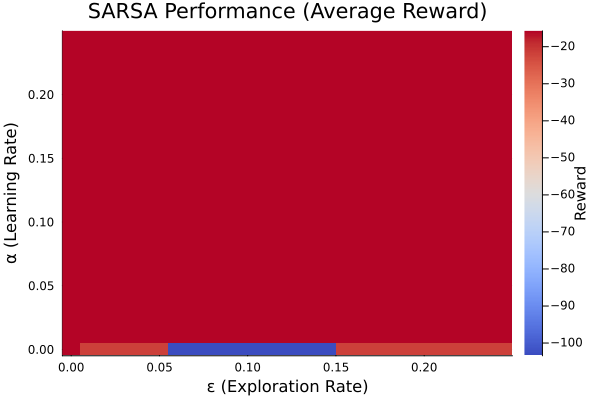

In [18]:
heatmap(
    epsilons,
    alphas,
    Z;
    xlabel = "ε (Exploration Rate)",
    ylabel = "α (Learning Rate)",
    title = "SARSA Performance (Average Reward)",
    colorbar_title = "Reward",
    c = :coolwarm,
    clims = (minimum(Z), maximum(Z))  # adjust color scaling
)
